In [57]:
#1) Import libraries
from qpsolvers import solve_qp#, Problem, solve_problem
import time
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Environments
import pandas as pd

In [58]:
#2) Create functions for quadratic computing
def H_funct(n):
    # H = np.zeros((3*n,3*n))
    H = np.diag([1e-5]*(3*n))
    for i in range(n):
        H[i*3+1,i*3+1] = 1.
    return H

def Q_funct(n,vd):
    Q = np.zeros((3*n,))
    for i in range(n):
        Q[i*3+1]=-vd
    return Q

def A2_funct(n,dt):
    A = np.zeros((2*n+1,3*n))
    for i in range(0,2):
        A[i,i]=1.
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1.
        A[i,j-3]=1.
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2.
    for i in range(2*n,2*n+1):
        j=i+(i//2)-3
        A[i,j]=1.
    return A

def A_funct(n,dt):
    A = np.zeros((2*n+1,3*n))
    for i in range(0,2):
        A[i,i]=1.
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0.
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1.
        A[i,j-3]=1.
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2.
    for i in range(2*n,2*n+1):
        j=i+(i//2)-3
        A[i,j+1]=1
    return A

def B2_funct(n,xi,xf):
    B = np.zeros((2*n+1,))
    B[0]=xi[0]
    B[1]=xi[1]
    B[2*n]=xf[0]
   # B[2*n+1]=xf[1]
    return B

def B_funct(n,xi,xf):
    B = np.zeros((2*n+1,))
    B[0]=xi[0]
    B[1]=xi[1]
    #B[2*n]=xf[0]
    B[2*n]=xf[1]
    return B

def bounds(n,bds):
    bounds= np.zeros((3*n))
    for i in range(n):
        bounds[i*3:i*3+3]=bds
    return bounds


In [59]:
#3) Quadratic programming model
class Model_QP():
    """
        Class: select action
        :param dt: time step
        :param lb: lower bounds [position, speed, acceleration]
        :param ub: upper bounds [position, speed, acceleration]
    """
    def __init__(self, dt, lb, ub):
        self.dt = dt
        self.lb = lb
        self.ub = ub
        
    def new_action_position(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A2_funct(n,self.dt)
        B=B2_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs, solver="quadprog")
        #solution= solve_problem(problem, solver="quadprog")
       #return solution = solve_problem(problem, solver="quadprog")
    
    def new_action_speed(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A_funct(n,self.dt)
        B=B_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs, solver="quadprog")

In [60]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
        :param dt: time step
        :param cross: size crosswalk
        :param acc_max: maximal acceleration
        :param acc_min: minimal acceleration
        :param tau: reaction time
    """
    def __init__(self, env, nb_cars, nb_peds, max_steps, dt, acc_max, acc_min, tau):
        self.env = env
        self.max_steps = max_steps
        self.dt = dt
        #self.cross = env.cross
        #self.cross_lines = env.nb_lines*env.cross
        self.prev_state = env.reset()
        self.acc_max=acc_max
        self.acc_min=acc_min
        self.tau=tau
        self.nb_cars=nb_cars
        self.nb_peds=nb_peds
        
    def reset(self):
        """
        Reset: reinitilization (lists et environment).
        """
        self.prev_state, _ = self.env.reset()

    def delta_l(self, x, v, ped_x):
        """
        Compute safety factor
        :param x: distance between the car and the crosswalk (negative value) 
        :param v: vehicle speed
        :return: safety factor
        """    
        return -(x - ped_x) - (v * v / (-2.0 * self.acc_min) + self.tau * v)
    
    def tranformation_action(self,value):
        """
        Transform the value for environment (before step iteration)
        :param value: element compute with QP
        :return: transformed value
        """  
        a=2./(self.acc_max-self.acc_min)
        b=-(self.acc_max+self.acc_min)/(self.acc_max-self.acc_min)
        return value#a*value+b
    
    
    def choice_action(self,model, state_car, state_ped, state_env, choice_car, ped_i, car_i):
        cross_lines = state_env[0]
        cross= (cross_lines*2) /self.env.nb_lines
        #cross_lines = self.env.nb_lines*state_env[0]/2
        line_start, line_end = (-cross_lines)+cross*(state_car[5]), (-cross_lines)+cross*(state_car[5]+1)
        dist_leave=(state_ped[3]-line_end)*(state_ped[8]>0) + (line_start-state_ped[3])*(state_ped[8]<0)
        ped_leave=(state_ped[3]>line_end)*(state_ped[8]>0) + (state_ped[3]<line_start)*(state_ped[8]<0)
        #if(choice_car<0):
        #    return [0., 0., 0.]
        car_parameters=[0., 0., 0.]
        initial_state = [state_car[3],state_car[1]]#relative position, speed -state_ped[2]
        if(state_car[3]>=state_ped[2] or ped_leave): # if car already pass the crosswalk state_ped[3]*state_ped[8]>=state_env[0]
            self.n=1+math.ceil((self.ds[car_i]-state_car[1])/(self.dt*self.acc_max))
            if(self.ds[car_i]-state_car[1]>0.):
                #print(self.ds[car_i])
                final_state = [(state_car[3])+self.n*self.ds[car_i]*self.dt, self.ds[car_i]]
                #print("final state ",final_state)
                car_parameters = model.new_action_speed(self.n, initial_state, final_state)
                #print("car_parameters ",car_parameters)
                #print("First ",car_parameters)
                if(car_parameters is None):
                    car_parameters=[0., 0., state_car[0]+0.01]
        else:
            #print("not finished",initial_state)
            if(state_car[1]<0.0):
                car_parameters=[0., 0., 0.01]
            elif(abs(state_ped[1])<0.01):
                final_state = [state_ped[2]-0.5, self.ds[car_i]]
                car_parameters = model.new_action_position(8, initial_state, final_state)
                while(car_parameters is None and self.n<20):
                    car_parameters = model.new_action_position(self.n, initial_state, final_state)
                    self.n=self.n+1
                if(car_parameters is None):
                    car_parameters=[0., 0., self.acc_min]
                #print("Second ",car_parameters)
            else:
                self.n=4+math.ceil((-dist_leave)/(self.dt*state_ped[8]*self.ped_speed[ped_i]))#state_env[0]-state_ped[8]*state_ped[3]
                #print(self.n)
                if(self.n==2):
                    acc=-2.*(state_car[1]*self.dt + state_car[3])/(self.dt**2)
                    car_parameters=[0., 0., acc]
                if(self.n>2):
                    final_state = [state_ped[2], self.ds[car_i]]
                    car_parameters = model.new_action_position(self.n, initial_state, final_state)
                    while(car_parameters is None and self.n<8):
                        car_parameters = model.new_action_position(self.n, initial_state, final_state)
                        self.n=self.n+1
                    if(car_parameters is None):
                        car_parameters=[0., 0., state_car[0]+0.1]
               #print("Third ",car_parameters)
        if(choice_car<0):
            car_parameters=[0., 0., 0.]
        #print("car_parameters ",car_parameters[0:3])
        return car_parameters[0:3]
    

    def closest_ped_d(self, obs, num_car):
        size_env=int(self.env.observation_space["env"].shape[0])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/self.env.nb_car)
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        min_ped=0
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        min_dist_ped=obs[size_car+size_env+2]-car_data[3]
        for num_ped in range(self.env.nb_ped):
            ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
            if(ped_data[2]-car_data[3]<min_dist_ped):
                min_dist_ped=ped_data[2]-car_data[3]
                min_ped=num_ped
        return min_ped        

    def iterations_dataset(self, model, nbr_episodes, choice=True):
        """
        Iterate on the environment.
        :param model: current policy
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        self.choice_car=[0]*self.nb_peds*self.nb_cars
        self.choice_car_all = np.loadtxt('decisions_d_dataset.txt', dtype=int)
        file = open("test_data_23.pickle",'rb')
        env_dataset = pickle.load(file)
        print(env_dataset)
        for ep in range(nbr_episodes):
            self.env=env_dataset[ep]
            state = self.env.get_state()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            self.ds=[state["car"][1+car_i*6] for car_i in range(self.nb_cars)]
            self.ped_speed=[state["ped"][1+ped_i*9] for ped_i in range(self.nb_peds)]
            if(choice):
                for car_i in range(self.nb_cars):
                    for ped_i in range(self.nb_peds):
                        self.choice_car[car_i*self.nb_peds+ped_i]=2*(self.delta_l(state["car"][3+car_i*6],state["car"][1+car_i*6],state["ped"][2+ped_i*9]) >= 0)-1
            else:
                self.choice_car=self.choice_car_all[ep]
                #self.choice_car = np.loadtxt('decisions_d_dataset.txt', dtype=int).flatten()
                #print(self.choice_car)
            self.n=0
            for step_ep in range(self.max_steps):
                actions_c=[]
                actions_d=[]
                for car_i in range(self.nb_cars):
                    choice_ped=self.closest_ped_d(prev_state,car_i)
                    #print(self.choice_car)
                    car_parameters_i=np.array([self.choice_action(model,
                                                             state["car"][car_i*6:(car_i+1)*6],
                                                             state["ped"][ped_i*9:(ped_i+1)*9],
                                                             state["env"][:],
                                                             self.choice_car[car_i*self.nb_peds+ped_i],
                                                             ped_i,
                                                             car_i)[0:3] for ped_i in range(self.nb_peds)]).flatten()
                    action_i=min([self.tranformation_action(car_parameters_i[2+3*ped_i]) for ped_i in range(self.nb_peds)])
                    actions_c.append(action_i)
                    actions_d.append(self.choice_car[car_i*self.nb_peds+choice_ped])
                acc_param = [(self.acc_max-self.acc_min)/2.0, (self.acc_max+self.acc_min)/2.0]
                actions_c=np.array([np.clip(actions_c[car_i],(-state["car"][1+car_i*6])/self.dt, (self.ds[car_i]-state["car"][1+car_i*6])/self.dt) for car_i in range(self.nb_cars)])
                actions_d=actions_d
                action_all=np.append(actions_c, actions_d)
                state, reward, done,trunc, _ = self.env.step(action_all)
                batch_obs.append(prev_state)
                batch_acts.append(actions_c)
                batch_rews.append(reward)
                prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews
    
    def iterations(self, model, nbr_episodes):
        """
        Iterate on the environment.
        :param model: current policy
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        self.choice_car=[0]*self.nb_peds*self.nb_cars
        for ep in range(nbr_episodes):
            state,_ = self.env.reset()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            self.ds=[state["car"][1+car_i*6] for car_i in range(self.nb_cars)]
            #print(self.ds)
            self.ped_speed=[state["ped"][1+ped_i*9] for ped_i in range(self.nb_peds)]
            for car_i in range(self.nb_cars):
                for ped_i in range(self.nb_peds):
                    self.choice_car[car_i*self.nb_peds+ped_i]=2*(self.delta_l(state["car"][3+car_i*6],state["car"][1+car_i*6],state["ped"][2+ped_i*9]) >= 0)-1

            self.n=0
            for step_ep in range(self.max_steps):
                actions_c=[]
                actions_d=[]
                for car_i in range(self.nb_cars):
                    #choice_car=[2*(self.delta_l(state["car"][3+car_i*6],state["car"][1+car_i*6],state["ped"][2+ped_i*9]) >= 0)-1 for ped_i in range(self.nb_peds)]
                    #print(choice_car)
                    choice_ped=self.closest_ped_d(prev_state,car_i)
                    #choice_car=(self.delta_l(state["car"][3+car_i*6],state["car"][1+car_i*6],state["ped"][2+ped_i*9]) >= 0)
                    car_parameters_i=np.array([self.choice_action(model,
                                                             state["car"][car_i*6:(car_i+1)*6],
                                                             state["ped"][ped_i*9:(ped_i+1)*9],
                                                             state["env"][:],
                                                             self.choice_car[car_i*self.nb_peds+ped_i],
                                                             ped_i,
                                                             car_i)[0:3] for ped_i in range(self.nb_peds)]).flatten()
                    #print("car_param_i",car_parameters_i)
                    action_i=min([self.tranformation_action(car_parameters_i[2+3*ped_i]) for ped_i in range(self.nb_peds)])
                    #print("action i ",action_i)
                    actions_c.append(action_i)
                    actions_d.append(self.choice_car[car_i*self.nb_peds+choice_ped])
                #print(np.array([np.clip([action],-1.0,1.0)[0],2*self.choice_car-1]))
                acc_param = [(self.acc_max-self.acc_min)/2.0, (self.acc_max+self.acc_min)/2.0]
                #action=action * acc_param[0] + acc_param[1]
                actions_c=np.array([np.clip(actions_c[car_i],(-state["car"][1+car_i*6])/self.dt, (self.ds[car_i]-state["car"][1+car_i*6])/self.dt) for car_i in range(self.nb_cars)])
                actions_d=actions_d#2*np.array(actions_d)-1
                #print("actions_c",actions_c)
                #print(actions_d)
                action_all=np.append(actions_c, actions_d)
                state, reward, done,trunc, _ = self.env.step(action_all)
                batch_obs.append(prev_state)
                batch_acts.append(actions_c)
                batch_rews.append(reward)
                prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews
    
    
    def tests_choice(self, model):
        """
        Iterate on the environment.
        :param model: current policy
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(4):
            state,_ = env.reset()
            self.choix_test_choice(ep)
            state=self.env.get_state()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            self.ds=state["car"][1]
            self.ped_speed=state["ped"][1]
            self.choice_car=(self.delta_l(state["car"][3], state["car"][1]) >= 0)
            for step_ep in range(self.max_steps):
                car_parameters=[0., 0., 0.]
                initial_state = [state["car"][3],state["car"][1]]#prev_state[1:3][1::-1]
                if(not self.choice_car):
                    car_parameters=[0., 0., 0.]
                else:
                    if(state["car"][3]>=state["ped"][2] or state["ped"][3]*state["ped"][8]>=state["env"][0]): # if car already pass the crosswalk
                        n=1+math.ceil((self.ds-state["car"][1])/(self.dt*self.acc_max))
                        if(self.ds-state["car"][1]>0.):
                            final_state = [state["car"][3]+n*self.ds*self.dt, self.ds]
                            car_parameters = model.new_action_speed(n, initial_state, final_state)
                            if(car_parameters is None):
                                car_parameters=[0., 0., state["car"][0]+0.1]
                    else:
                        if(state["car"][1]<0.0):
                            car_parameters=[0., 0., 0.2]
                        elif(abs(state["ped"][1])<0.1):
                            final_state = [0., self.ds]
                            car_parameters = model.new_action_position(8, initial_state, final_state)
                            while(car_parameters is None and n<20):
                                car_parameters = model.new_action_position(n, initial_state, final_state)
                                n=n+1
                            if(car_parameters is None):
                                car_parameters=[0., 0., self.acc_min]
                        else:
                            n=4+math.ceil((state["env"][0]-state["ped"][8]*state["ped"][3])/(self.dt*state["ped"][8]*self.ped_speed))
                            if(n==2):
                                acc=-2.*(state["car"][1]*self.dt + state["car"][3])/(self.dt**2)
                                car_parameters=[0., 0., acc]
                            if(n>2):
                                final_state = [0., self.ds]
                                car_parameters = model.new_action_position(n, initial_state, final_state)
                                while(car_parameters is None and n<8):
                                    car_parameters = model.new_action_position(n, initial_state, final_state)
                                    n=n+1
                                if(car_parameters is None):
                                    car_parameters=[0., 0., state["car"][0]+0.2]
                action=self.tranformation_action(car_parameters[2])
                #print(np.array([np.clip([action],-1.0,1.0)[0],2*self.choice_car-1]))
                acc_param = [(self.acc_max-self.acc_min)/2.0, (self.acc_max+self.acc_min)/2.0]
                #action=action * acc_param[0] + acc_param[1]
                action=np.clip(action,(-state["car"][1])/self.dt, (self.ds-state["car"][1])/self.dt )
                state, reward, done,trunc, _ = self.env.step(np.array([action,2*self.choice_car-1]))
                batch_obs.append(prev_state)
                batch_acts.append(car_parameters[2])
                batch_rews.append(reward)
                prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews

    def tests_cross_wait(self, model):
        """
        Iterate on the environment.
        :param model: current policy
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(4):
            state,_ = env.reset()
            self.choice_car=self.choix_test_cross_wait(ep)
            state=self.env.get_state()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            self.ds=state["car"][1]
            self.ped_speed=state["ped"][1]
            #self.choice_car=(self.delta_l(state["car"][3], state["car"][1]) >= 0)
            for step_ep in range(self.max_steps):
                car_parameters=[0., 0., 0.]
                initial_state = [state["car"][3],state["car"][1]]#prev_state[1:3][1::-1]
                if(state["car"][3]>=state["ped"][2] or state["ped"][3]*state["ped"][8]>=state["env"][0]): # if car already pass the crosswalk
                    n=1+math.ceil((self.ds-state["car"][1])/(self.dt*self.acc_max))
                    if(self.ds-state["car"][1]>0.):
                        final_state = [state["car"][3]+n*self.ds*self.dt, self.ds]
                        car_parameters = model.new_action_speed(n, initial_state, final_state)
                        if(car_parameters is None):
                            car_parameters=[0., 0., state["car"][0]+0.1]
                else:
                    if(state["car"][1]<0.0):
                        car_parameters=[0., 0., 0.2]
                    elif(abs(state["ped"][1])<0.1):
                        final_state = [0., self.ds]
                        car_parameters = model.new_action_position(8, initial_state, final_state)
                        while(car_parameters is None and n<20):
                            car_parameters = model.new_action_position(n, initial_state, final_state)
                            n=n+1
                        if(car_parameters is None):
                            car_parameters=[0., 0., self.acc_min]
                    else:
                        n=4+math.ceil((state["env"][0]-state["ped"][8]*state["ped"][3])/(self.dt*state["ped"][8]*self.ped_speed))
                        if(n==2):
                            acc=-2.*(state["car"][1]*self.dt + state["car"][3])/(self.dt**2)
                            car_parameters=[0., 0., acc]
                        if(n>2):
                            final_state = [0., self.ds]
                            car_parameters = model.new_action_position(n, initial_state, final_state)
                            while(car_parameters is None and n<8):
                                car_parameters = model.new_action_position(n, initial_state, final_state)
                                n=n+1
                            if(car_parameters is None):
                                car_parameters=[0., 0., state["car"][0]+0.2]
                if(not self.choice_car):
                    car_parameters=[0., 0., 0.]
                action=self.tranformation_action(car_parameters[2])
                #print(np.array([np.clip([action],-1.0,1.0)[0],2*self.choice_car-1]))
                acc_param = [(self.acc_max-self.acc_min)/2.0, (self.acc_max+self.acc_min)/2.0]
                #action=action * acc_param[0] + acc_param[1]
                action=np.clip(action,(-state["car"][1])/self.dt, (self.ds-state["car"][1])/self.dt )
                state, reward, done,trunc, _ = self.env.step(np.array([action,2*self.choice_car-1]))
                batch_obs.append(prev_state)
                batch_acts.append(car_parameters[2])
                batch_rews.append(reward)
                prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews

        
    def choix_test_choice(self,value):
        if(value==0):
            self.env.reset_pedestrian(0, 0., 1.25, 0., -self.env.state["env"][0]-4.0, 0, 0, 0, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -15, 0., 0.)

        elif(value==1):
            self.env.reset_pedestrian(0, 0., 1.25, 0.,- self.env.state["env"][0]-0.5, 0, 0, 0, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -40, 0., 0.)

        elif(value==2):
            self.env.reset_pedestrian(0, 0., 1.25, 0.,- self.env.state["env"][0]-0.5, 0, 0, 0, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -15, 0., 0.)

        elif(value==3):
            self.env.reset_pedestrian(0, 0., 1.25, 0.,- self.env.state["env"][0]-4.0, 0, 0, 0, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -40, 0., 0.)

        
    def choix_test_cross_wait(self,value):
        if(value==0):
            small_breakpoint = env.state["car"][1]*0.5+self.env.state["car"][1] * self.env.state["car"][1] /8
            self.env.reset_pedestrian(0, 0., 1.25, 0.,- self.env.state["env"][0]-0.2, 0, 0, 1, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -small_breakpoint, 0., 0.)
            return [1]

        elif(value==1):
            small_breakpoint = self.env.state["car"][1]*0.5+self.env.state["car"][1] * self.env.state["car"][1] /8
            self.env.reset_pedestrian(0, 0., 1.25, 0.,- self.env.state["env"][0]-0.2, 0, 0, 0, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -small_breakpoint, 0., 0.)
            return [-1]

        elif(value==2):
            if self.env.state["env"][2]==2: # may not work !!! 
                self.env.reset_pedestrian(0, 0., 1.25, 0.,- 0.4, 0, 0, 1, 1, 1)
                self.env.reset_cars(1, self.env.state["car"][1], -15, -1., 1.)
                self.env.reset_cars(0, self.env.state["car"][1], -40, 1., 0.)
                return [1,-1]
            else:
                self.env.reset_pedestrian(0, 0., 1.25, 0.,- self.env.state["env"][0]-4.0, 0, 0, 0, 1, 1)
                self.env.reset_cars(0, self.env.state["car"][1], -40, 0., 0.)
                return [1]

        elif(value==3):
            self.env.reset_pedestrian(0, 0., 0.75, 0.,- self.env.state["env"][0]-0.1, 0, 0, 1, 1, 1)
            self.env.reset_cars(0, self.env.state["car"][1], -30, 1., 0.)
            return [1]


In [61]:
#4) QP Algorithm:
class Algo_QP():
    """ 
    QP algorithm : testing
    :param policy_class: policy
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.model = policy_class(self.dt, self.l_b, self.u_b)
        self.rollout = Env_rollout(env, self.nb_car, self.nb_ped, self.max_steps, self.dt, self.u_b[2], self.l_b[2], self.tau)
        self.cross=env.cross
        
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        state_batch, action_batch, rewards_batch = self.rollout.iterations(self.model, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def evaluate_dataset(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        state_batch, action_batch, rewards_batch = self.rollout.iterations_dataset(self.model, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def tests_cross_wait(self):
        """
        Testing
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rewards_batch = self.rollout.tests_cross_wait(self.model)
        return state_batch, action_batch, rewards_batch
    
    def tests_choice(self):
        """
        Testing
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rewards_batch = self.rollout.tests_choice(self.model)
        return state_batch, action_batch, rewards_batch
    
    
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.dt = 0.3
        self.cross = 5.0
            

In [62]:
#5) Computing part:
# Import environment
#problem = "Crosswalk_hybrid_multi_opti7_3-v0"
problem = "Crosswalk_hybrid_multi_naif-v0"
car_b = np.array([[ -4.0,  10.], [ 2.0, 10.]]) # acceleration and speed of the car
ped_b = np.array([[ -0.05, 0.75, 0.0, -3.0], [ 0.05, 1.75, 4., -0.5]]) # speed x, y , position x, y of the pedestrian  [ajout 4 en 3]
cross_b = np.array([2.5, 3.0]) # cross min/max, car nbr,  ped nbr
max_episode=80
nb_car=2
nb_ped=1
nb_lines=2
env = gym.make(problem, car_b=car_b, ped_b= ped_b, cross_b=cross_b, nb_car=nb_car, nb_ped=nb_ped, nb_lines=nb_lines, dt=0.3,
               max_episode=max_episode, simulation="sin")

# Initialize the algorithm
num_states = env.observation_space["car"].shape[0]+env.observation_space["ped"].shape[0]+env.observation_space["env"].shape[0]
num_actions = env.action_space.shape[0]

num_actions = 1
num_algo=1
u_b2=[200.0,15.0,2.0]
l_b2=[-45.0,0.0,-4.0]
algo=Algo_QP(Model_QP, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions,l_b=l_b2, u_b=u_b2, tau=1.0,  nb_car=nb_car, nb_ped= nb_ped)
#algo.loading(1,1000)

WARN: Box bound precision lowered by casting to float32
WARN: The obs returned by the `reset()` method is not within the observation space.


In [63]:
import copy
env.reset()
print(env.pedestrian[0].initial_speed)
print(env.pedestrian[0].initial_pos)
new_env=copy.copy(env)
print(new_env.pedestrian[0].initial_speed)
print(new_env.pedestrian[0].initial_pos)
env.reset()
print(env.pedestrian[0].initial_speed)
print(env.pedestrian[0].initial_pos)
print(new_env.pedestrian[0].initial_speed)
print(new_env.pedestrian[0].initial_pos)

[-0.04920539920558044, -1.2006546037669958]
[0.9457360445337768, 5.058771535898938]
[-0.04920539920558044, -1.2006546037669958]
[0.9457360445337768, 5.058771535898938]
[0.007446952319450764, -1.1871278809993395]
[1.5925311456159656, 3.6318122705572797]
[0.007446952319450764, -1.1871278809993395]
[1.5925311456159656, 3.6318122705572797]


In [16]:
#import pickle
# 
#def save_object(obj):
#    try:
#        with open("test.pickle", "wb") as f:
#            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
#    except Exception as ex:
#        print("Error during pickling object (Possibly unsupported):", ex)
#        
#save_object([env,new_env])

In [ ]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(100)
states=np.array(states)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,3]
ep_speed_ped=states[:,9+1]
ep_pos_ped=states[:,9+3]
#ep_time=states[:,9]
ep_reward=rewards
t=0

lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,env.nb_car,int(lim_car/env.nb_car))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0

In [ ]:
import pandas as pd
LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        for car_i in range(env.nb_car):
            while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                acc=math.trunc(((ep_car[t,car_i,0].item()//0.2)*0.2)*10.)/10.
                speed=math.trunc(((ep_car[t,car_i,1].item()//0.5)*0.5)*10.)/10.
                cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
                res=LDV[cond]['em_val'].item() *0.3
                emission_val.append(res)
                t+=1
            total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(ep_car[:,0,1])
    sqrt_speed=torch.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(torch.abs(ep_car[:,0,0]))
    sqrt_acc=torch.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(torch.abs(ep_ped[:,0,1]))
    sqrt_speed_p=torch.std(torch.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    #temps passage voiture
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    decisions=[]
    ped_direction=[]
    waiting_times=[]
    speed_cars=[]
    all_decisions=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #if(1 in ep_car[t_init+1,:,4]):
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if(ep_ped[t,ped_i,3])==ep_cross[t]:
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    temp_peds.append((t-t_init)*0.3)
                t+=1
            waiting_times.append(waiting_time)
            ped_direction.append(int(-ep_ped[t_init,ped_i,8]/2. +0.5))
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t_init+1,car_i,4]==1):
                    speed_cars.append(ep_car[t,car_i,1])
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0):
                    all_temp_cars.append((t-t_init)*0.3)
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0)and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                    #speed_cars.append(ep_car[t,car_i,1])
                t+=1
            decisions.append(decision)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=np.mean(torch.tensor(speed_cars).flatten())
    sqrt_speed_cars=torch.std(torch.tensor(speed_cars).flatten())
    mean_temp_cars=torch.mean(torch.tensor(temp_cars).flatten())
    mean_all_temp_cars=torch.mean(torch.tensor(all_temp_cars).flatten())
    mean_temp_peds=torch.mean(torch.tensor(temp_peds).flatten())
    decisions_tensor=torch.tensor(decisions).reshape(-1,env.nb_car)
    scenario=torch.sum(decisions_tensor, axis=1)
    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))

    print("\nLes temps moyens:")
    print("voiture 1: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 std: ", torch.std(torch.tensor(temp_cars)))
    print("voiture all: {:.2f} s".format(mean_all_temp_cars))
    print("voiture all std: ", torch.std(torch.tensor(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", torch.std(torch.tensor(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(decisions) if dec ==1])/len(decisions))
    print("Go first decision: ", sum([1 for dec in np.array(decisions) if dec ==-1])/len(decisions))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    if(env.nb_car==2):
        size_scenario=len(decisions_tensor)
        print("Scenario 11: ", sum([1 for i in range(size_scenario) if sum(decisions_tensor[i]) ==2])/len(scenario))
        print("Scenario -1-1: ", sum([1 for i in range(size_scenario) if sum(decisions_tensor[i]) ==-2])/len(scenario))
        print("Scenario -1 1: ", sum([1 for i in range(size_scenario) if decisions_tensor[i][ped_direction[i]] ==-1 and decisions_tensor[i][1-ped_direction[i]]==1])/len(scenario))
        print("Scenario 1 -1: ", sum([1 for i in range(size_scenario) if decisions_tensor[i][ped_direction[i]] ==1 and decisions_tensor[i][1-ped_direction[i]]==-1])/len(scenario))
    #print(torch.std(total_temps,dim=0))
get_average(ep_car,ep_ped,ep_cross)


In [64]:

import pickle
#Stock an evaluation sample
car_feat_size=6
env_feat_size=3
ped_feat_size=8
states, actions, rewards_c = algo.evaluate_dataset(1)
#ep_action=states[:,0]
#ep_speed_car=states[:,1]
#ep_pos_car=states[:,2]
#ep_speed_ped=states[:,3]
#ep_pos_ped=states[:,4]
#ep_cross=states[:,9]
#ep_reward_d=rewards_d
ep_reward_c=rewards_c
#ep_light=actions[:,1]

lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
states=np.array(states)
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,env.nb_car,int(lim_car/env.nb_car))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0
u=0
num_episode=0
#t_init=t
#print(ep_reward_c.shape)
#print(ep_reward_d.shape)
#print(actions)
#ep_reward_d.flatten()

[<TimeLimit<OrderEnforcing<PassiveEnvChecker<Crosswalk_hybrid_multi_naif<Crosswalk_hybrid_multi_naif-v0>>>>>]
Episode * 0 * Avg Reward is ==> -9.574272358737236 And Number of steps is ==> 0


divide by zero encountered in scalar divide
`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
WARN: The obs returned by the `step()` method is not within the observation space.
WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>


light :  1.0
line :  0.0
light :  1.0
line :  1.0
Reward discrete  [-0.27731143 -0.13331143]


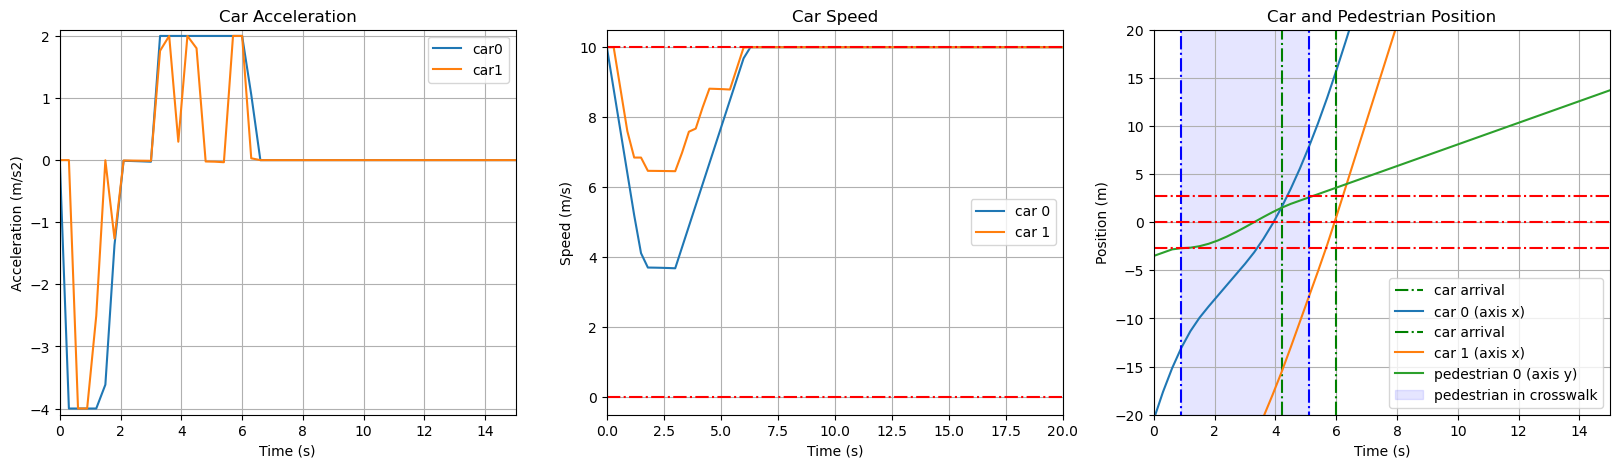

In [44]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
t=0
if(t+1>=len(ep_cross)):
    t=0
    u=0
t_init=t
x_car=[t_init]*env.nb_car
x_ped1=[t_init]*env.nb_ped
x_ped2=[t_init]*env.nb_ped
while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
    for i in range(env.nb_ped):
        direction=ep_ped[t_init,i,1]/abs(ep_ped[t_init,i,1])
        if(ep_ped[t,i,3]*direction<=-ep_cross[t_init] and ep_ped[t+1,i,3]*direction>-ep_cross[t_init]):
            x_ped1[i]=t
        if(ep_ped[t,i,3]*direction<=ep_cross[t_init] and ep_ped[t+1,i,3]*direction>ep_cross[t_init]):
            x_ped2[i]=t
    
    for i in range(env.nb_car):
        if(ep_car[t,i,3]<ep_ped[t,0,2] and ep_car[t+1,i,3]>ep_ped[t+1,0,2]): #car finish crossing
            x_car[i]=t
    t+=1
    
for i in range(env.nb_car):
    if(x_car[i]==t_init):
        x_car[i]=t
cross_lines=ep_env[t_init,0]
cross=int((ep_env[t_init,0]*2)/ep_env[t_init,2])

ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 5))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.1,2.1)
ax1.set_xlim(0,15)
for id_car in range(env.nb_car):
    ax1.plot(ep_time, ep_car[t_init:t+1,id_car,0],label='car'+str(id_car)) #-ep_cross[t_init]
ax1.legend()
ax1.grid()

ax3.set_title('Car and Pedestrian Position')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Position (m)")
for id_car in range(env.nb_car):
    ax3.axvline(x=(x_car[id_car]-t_init)*0.3, color='g', linestyle='-.',label='car arrival')
    #print(ep_car[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_ped[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_env[(x_car[id_car])])
    ax3.plot(ep_time, ep_car[t_init:t+1,id_car,3],label='car '+str(id_car)+' (axis x)') #-ep_cross[t_init] -ep_ped[t_init:t+1,0,2]
    print("light : ",ep_car[t_init+1,id_car,4])
    print("line : ",ep_car[t_init+1,id_car,5])
for id_ped in range(env.nb_ped):
    ax3.plot(ep_time, ep_ped[t_init:t+1,id_ped,3],label='pedestrian '+str(id_ped)+' (axis y)')
    direction=ep_ped[t_init,id_ped,1]/abs(ep_ped[t_init,id_ped,1])
    if direction:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
    else:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
    ax3.fill_between([(x_ped1[id_ped]-t_init)*0.3,(x_ped2[id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.1,label='pedestrian in crosswalk')
    #ax2.fill_between([(x_ped1-t_init)*0.3,(x_ped2-t_init)*0.3], min(ep_pos_car[t_init],ep_pos_ped[t_init]), min(max(ep_pos_car[min_t+t_init],ep_pos_ped[min_t+t_init]),30), color='r', alpha=0.1,label='pedestrian in crosswalk')
ax3.set_ylim(-20,20)
ax3.set_xlim(0,15)
cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
for i in range(int(ep_env[t_init,2])+1):
    ax3.axhline(y=-ep_cross[t_init] + i*cross_size , color='r', linestyle='-.')
#ax2.axhline(y=0.0, color='b', linestyle='-.')
#ax2.axhline(y=10.0, color='b', linestyle='-.')
ax3.legend()
ax3.grid()

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
for id_car in range(env.nb_car):
    ax2.plot(ep_time, ep_car[t_init:t+1,id_car,1],label='car '+str(id_car)) #-ep_cross[t_init]
#ax3.plot(ep_time, ep_speed_car[t_init:t+1],color='r')
ax2.axhline(y=ep_car[t_init,0,1], color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.set_xlim(0,20)
ax2.legend()
ax2.grid()
#ax4.set_title('Pedestrian Speed')
#ax4.set_xlabel("Time (s)")
#ax4.set_ylabel("Speed (m/s)")
#for id_ped in range(env.nb_ped):
#    ax4.plot(ep_time, abs(ep_ped[t_init:t+1,id_ped,1]),label='pedestrian '+str(id_ped))
    #ep_ped[t_init:t+1,id_ped,7]*
##ax4.set_xlim(0,15)
#ax4.legend()
#fig.savefig("Display_Data/Sauvegarde_"+str(is_loading_c)+"_"+str(int(ep_car[t_init+1,0,4]))+"_"+str(int(ep_car[t_init+1,1,4]))+".pdf")    
#print(ep_reward_d)
print("Reward discrete ",ep_reward_c[u])
t+=1
u+=1
#print(t)
#print(ep_reward_d[u])

[<TimeLimit<OrderEnforcing<PassiveEnvChecker<Crosswalk_hybrid_multi_naif<Crosswalk_hybrid_multi_naif-v0>>>>>]
Episode * 0 * Avg Reward is ==> -9.574272358737236 And Number of steps is ==> 0
light :  -1.0
line :  0.0
light :  1.0
line :  1.0
num_episode :  0
t :  80


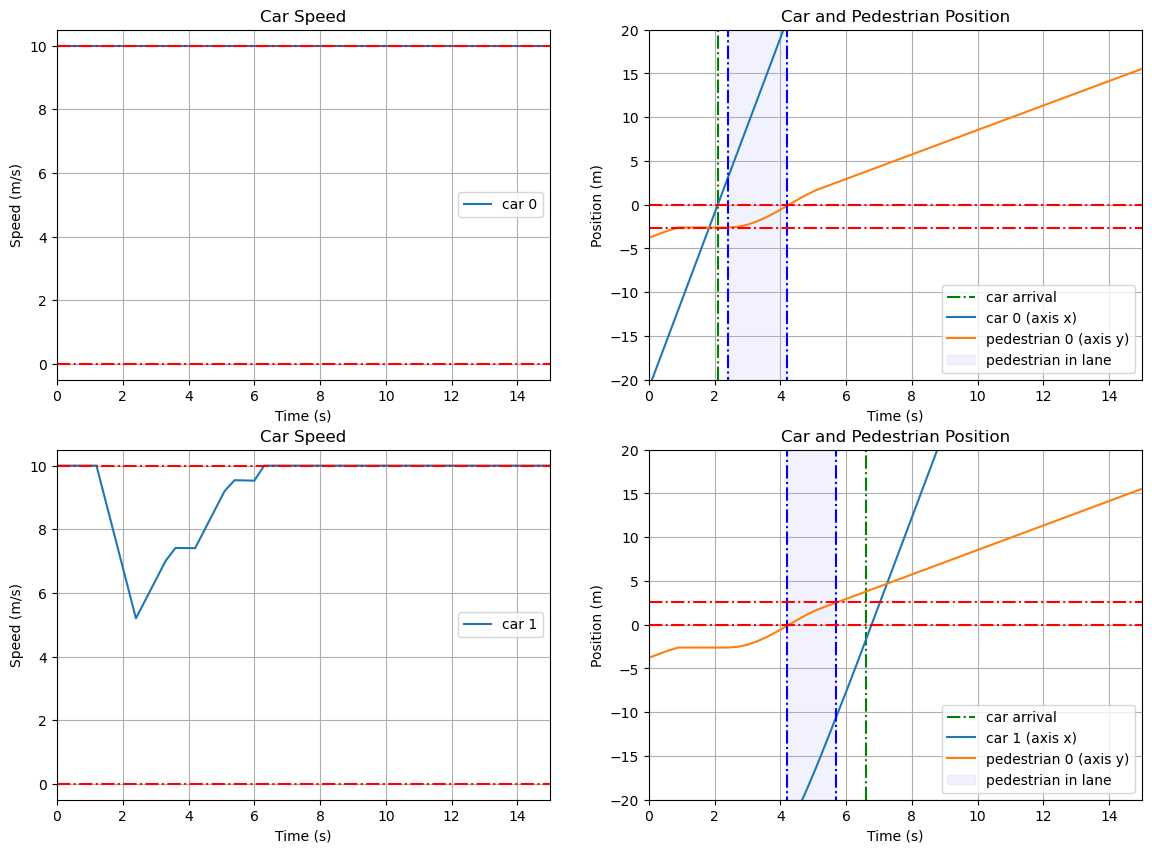

In [65]:
import pickle
car_feat_size=6
env_feat_size=3
ped_feat_size=8#.evaluate(1000)
states, actions, reward_c = algo.evaluate_dataset(1)#evaluate_dataset(100)
#ep_action=states[:,0]
#ep_speed_car=states[:,1]
#ep_pos_car=states[:,2]
#ep_speed_ped=states[:,3]
#ep_pos_ped=states[:,4]
#ep_cross=states[:,9]

#ep_light=actions[:,1]
states=np.array(states)

lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,env.nb_car,int(lim_car/env.nb_car))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0
u=0
num_episode=0
if(t+1>=len(ep_cross)):
    t=0
    u=0
t_init=t
x_car=[t_init]*env.nb_car
x_ped1=[t_init]*env.nb_ped
x_ped2=[t_init]*env.nb_ped
x_ped3=[t_init]*env.nb_ped
while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
    for i in range(env.nb_ped):
        direction=ep_ped[t_init,i,1]/abs(ep_ped[t_init,i,1])
        #cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
        if(ep_ped[t,i,3]*direction<=-ep_cross[t_init] and ep_ped[t+1,i,3]*direction>-ep_cross[t_init]):
            x_ped1[i]=t
        if(ep_ped[t,i,3]*direction<=0. and ep_ped[t+1,i,3]*direction>0.):
            x_ped2[i]=t
        if(ep_ped[t,i,3]*direction<=ep_cross[t_init] and ep_ped[t+1,i,3]*direction>ep_cross[t_init]):
            x_ped3[i]=t
    
    for i in range(env.nb_car):
        if(ep_car[t,i,3]<ep_ped[t,0,2] and ep_car[t+1,i,3]>ep_ped[t+1,0,2]): #car finish crossing
            x_car[i]=t
    t+=1
    
for i in range(env.nb_car):
    if(x_car[i]==t_init):
        x_car[i]=t
cross_lines=ep_env[t_init,0]
cross=int((ep_env[t_init,0]*2)/ep_env[t_init,2])
x_ped=[x_ped1,x_ped2,x_ped3]
ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, axs = plt.subplots(2, 2,figsize=(14, 10))
for axe_x in range(len(axs)):
    axs[axe_x][0].set_title('Car Speed')
    axs[axe_x][0].set_xlabel("Time (s)")
    axs[axe_x][0].set_ylabel("Speed (m/s)")
    #for id_car in range(env.nb_car):
    axs[axe_x][0].plot(ep_time, ep_car[t_init:t+1,axe_x,1],label='car '+str(axe_x)) #-ep_cross[t_init]
    #ax3.plot(ep_time, ep_speed_car[t_init:t+1],color='r')
    axs[axe_x][0].axhline(y=ep_car[t_init,0,1], color='r', linestyle='-.')
    axs[axe_x][0].axhline(y=0, color='r', linestyle='-.')
    axs[axe_x][0].set_xlim(0,15)
    axs[axe_x][0].legend()
    axs[axe_x][0].grid()
    
    axs[axe_x][1].set_title('Car and Pedestrian Position')
    axs[axe_x][1].set_xlabel("Time (s)")
    axs[axe_x][1].set_ylabel("Position (m)")
    axs[axe_x][1].axvline(x=(x_car[axe_x]-t_init)*0.3, color='g', linestyle='-.',label='car arrival')
    #print(ep_car[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_ped[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_env[(x_car[id_car])])
    axs[axe_x][1].plot(ep_time, ep_car[t_init:t+1,axe_x,3],label='car '+str(axe_x)+' (axis x)') #-ep_cross[t_init] -ep_ped[t_init:t+1,0,2]
    print("light : ",ep_car[t_init+1,axe_x,4])
    print("line : ",ep_car[t_init+1,axe_x,5])
    for id_ped in range(env.nb_ped):
        axs[axe_x][1].plot(ep_time, ep_ped[t_init:t+1,id_ped,3],label='pedestrian '+str(id_ped)+' (axis y)')
        direction=ep_ped[t_init,id_ped,1]/abs(ep_ped[t_init,id_ped,1])
        car_lane=int(ep_car[t_init+1,axe_x,5])
        #print(direction)
        if direction>0:
            axs[axe_x][1].axvline(x=(x_ped[car_lane][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].axvline(x=(x_ped[car_lane+1][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].fill_between([(x_ped[car_lane][id_ped]-t_init)*0.3,(x_ped[car_lane+1][id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.05,label='pedestrian in lane')

        else:
            #print(ep_env[t_init,2]-car_lane)
            axs[axe_x][1].axvline(x=(x_ped[int(ep_env[t_init,2])-car_lane][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].axvline(x=(x_ped[int(ep_env[t_init,2])-car_lane-1][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].fill_between([(x_ped[int(ep_env[t_init,2])-car_lane][id_ped]-t_init)*0.3,(x_ped[int(ep_env[t_init,2])-car_lane-1][id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.05,label='pedestrian in lane')
        #ax2.fill_between([(x_ped1-t_init)*0.3,(x_ped2-t_init)*0.3], min(ep_pos_car[t_init],ep_pos_ped[t_init]), min(max(ep_pos_car[min_t+t_init],ep_pos_ped[min_t+t_init]),30), color='r', alpha=0.1,label='pedestrian in crosswalk')
    axs[axe_x][1].set_ylim(-20,20)
    axs[axe_x][1].set_xlim(0,15)
    cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
    for i in range(2):#int(ep_env[t_init,2])+1):
        axs[axe_x][1].axhline(y=-ep_cross[t_init] + (ep_car[t_init+1,axe_x,5]+i)*cross_size , color='r', linestyle='-.')
    #ax2.axhline(y=0.0, color='b', linestyle='-.')
    #ax2.axhline(y=10.0, color='b', linestyle='-.')
    axs[axe_x][1].legend()
    axs[axe_x][1].grid()
    
t+=1
u+=1
print("num_episode : ",num_episode)
print("t : ",t)
num_episode+=1

#print(t)
#print(ep_reward_d[u])

In [56]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
            acc=math.trunc(((ep_car[t,0,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((ep_car[t,0,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))

def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=np.mean(ep_car[:,0,1])
    sqrt_speed=np.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=np.mean(np.abs(ep_car[:,0,0]))
    sqrt_acc=np.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=np.mean(np.abs(ep_ped[:,0,1]))
    sqrt_speed_p=np.std(np.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    finish_cross_interact=[]
    finish_cross_nointeract=[]
    decisions=[]
    ped_direction=[]
    waiting_times=[]
    speed_cars=[]
    all_decisions=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            ped_leave=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if abs(ep_ped[t,ped_i,3])==ep_cross[t] and abs(ep_ped[t+1,ped_i,3])==ep_cross[t+1]:
                #if(ep_ped[t,ped_i,1]==0.):
                    waiting_time+=0.3
                if abs(ep_ped[t,ped_i,3])==0 and abs(ep_ped[t+1,ped_i,3])==0:
                #if(ep_ped[t,ped_i,1]==0.):
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    ped_leave=(t-t_init)*0.3
                t+=1
            if(ped_leave==0):
                ped_leave=(t-t_init)*0.3
            temp_peds.append(ped_leave)
            finish_cross_interact.append(ped_leave)
            finish_cross_nointeract.append(ped_leave-waiting_time)
            waiting_times.append(waiting_time)
            ped_direction.append(int(-ep_ped[t_init,ped_i,8]/2. +0.5))
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            car_leave=0
            finish_cross_nointeract.append((25.-ep_car[t_init,car_i,3])/ep_car[t_init,car_i,1])
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t_init+1,car_i,4]==1):
                    speed_cars.append(ep_car[t,car_i,1])
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])-25<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])-25>=0.0):
                    car_leave=(t-t_init)*0.3
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])-25<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])-25>=0.0)and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                    #speed_cars.append(ep_car[t,car_i,1])
                t+=1
            #if(ep_car[t_init+1,car_i,4]==1):
            #    decisions.append(decision)
            if(car_leave==0):
                car_leave=(t-t_init)*0.3
            all_decisions.append(decision)
            all_temp_cars.append(car_leave)
            finish_cross_interact.append(car_leave)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=np.mean(np.array(speed_cars).flatten())
    sqrt_speed_cars=np.std(np.array(speed_cars).flatten())
    mean_temp_cars=np.mean(np.array(temp_cars).flatten())
    mean_all_temp_cars=np.mean(np.array(all_temp_cars).flatten())
    mean_temp_peds=np.mean(np.array(temp_peds).flatten())
    #decisions_tensor=np.array(decisions).reshape(-1,env.nb_car)
    #scenario=np.sum(decisions_tensor, axis=1)
    all_decisions_tensor=np.array(all_decisions).reshape(-1,env.nb_car)
    #scenario=torch.sum(decisions_tensor, axis=1)
    #print(all_decisions_tensor)
    #scenario=torch.sum(decisions_tensor, axis=1)
    all_scenario=np.sum(all_decisions_tensor, axis=1)
    max_finish_cross_interact=np.max(np.array(finish_cross_interact).reshape(-1,env.nb_car+env.nb_ped),axis=1)
    max_finish_cross_nointeract=np.max(np.array(finish_cross_nointeract).reshape(-1,env.nb_car+env.nb_ped),axis=1)
    max_finish_compare=(np.array(finish_cross_interact).reshape(-1,env.nb_car+env.nb_ped)-np.array(finish_cross_nointeract).reshape(-1,env.nb_car+env.nb_ped))#,axis=1)
    interaction_cost=max_finish_cross_interact-max_finish_cross_nointeract
    
    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))
    print("Le cout de l'interaction est de :",np.mean(interaction_cost))
    print("Le cout max de l'interaction est de :",np.mean(max_finish_compare))
    print("\nLes temps moyens:")
    print("voiture 1 a 25 metres: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 a 25 metres std: ", np.std(np.array(temp_cars)))
    print("voiture all a 25 metres: {:.2f} s".format(mean_all_temp_cars))
    print("voiture all a 25 metres std: ", np.std(np.array(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", np.std(np.array(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(all_decisions) if dec ==1])/len(all_decisions))
    print("Go first decision: ", sum([1 for dec in np.array(all_decisions) if dec ==-1])/len(all_decisions))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    if(env.nb_car==2):
        size_scenario=len(all_decisions_tensor)
        print("Scenario 11: ", sum([1 for i in range(size_scenario) if sum(all_decisions_tensor[i]) ==2])/len(all_scenario))
        print("Scenario -1-1: ", sum([1 for i in range(size_scenario) if sum(all_decisions_tensor[i]) ==-2])/len(all_scenario))
        print("Scenario -1 1: ", sum([1 for i in range(size_scenario) if all_decisions_tensor[i][ped_direction[i]] ==-1 and all_decisions_tensor[i][1-ped_direction[i]]==1])/len(all_scenario))
        print("Scenario 1 -1: ", sum([1 for i in range(size_scenario) if all_decisions_tensor[i][ped_direction[i]] ==1 and all_decisions_tensor[i][1-ped_direction[i]]==-1])/len(all_scenario))

get_average(ep_car,ep_ped,ep_cross)

La vitesse moyenne (voiture) est de 9.22 m/s et son écart-type est de 1.97 m/s

L'accélération moyenne (voiture) est de 0.31 m/s2 et son écart-type est de 0.92 m/s2

La vitesse moyenne (piéton) est de 1.23 m/s et son écart-type est de 0.42 m/s

The average CO2 emission is 53698.77mg and its standard deviation is 2881.39 mg
La vitesse moyenne (voiture 1) est de 8.96 m/s et son écart-type est de 2.23 m/s
Le cout de l'interaction est de : 2.345279159927368
Le cout max de l'interaction est de : 1.4583368489980695

Les temps moyens:
voiture 1 a 25 metres: 9.78 s
voiture 1 a 25 metres std:  2.537486192120846
voiture all a 25 metres: 8.35 s
voiture all a 25 metres std:  3.437844757620681
piéton: 6.48 s
piéton std:  2.1927263303932842
Yield decision:  0.7615
Go first decision:  0.2385
Le temps moyen d'attente du pieton:  0.5037
Le temps std d'attente du pieton:  1.244908153238623
Scenario 11:  0.579
Scenario -1-1:  0.056
Scenario -1 1:  0.198
Scenario 1 -1:  0.167
